# Visualize phylogenetic tree
This Python Jupyter notebook analyzes and visualizes the Spike phylogenetic tree.

## Imports and configuration
Import modules and read configuration file:

In [15]:
import collections
import os
import io

import ete3

from IPython.display import display, HTML

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import yaml

Read configuration:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)
    
os.makedirs(config['tree_dir'], exist_ok=True)

Read various metadata:

In [3]:
metadata = pd.read_csv(config['spikes_metadata'])

Color-blind palette:

In [4]:
cbPalette = ("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

## Visualize phylogenetic tree
We will color nodes by the country of isolation, so first map country to color:

Saving legend to results/tree/legend.pdf


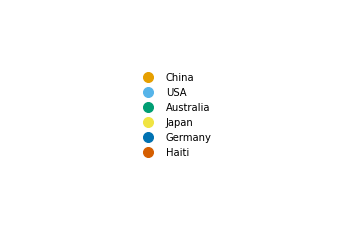

In [5]:
# map country and strain name to color
country_to_color = dict(zip(metadata.groupby('country')
                                    .aggregate(count=pd.NamedAgg('name', 'count'))
                                    .sort_values('count', ascending=False)
                                    .index,
                             cbPalette[1:]))
name_to_country = metadata.set_index('name')['country'].to_dict()

# draw a legend for the country to color mapping
# for circles: https://stackoverflow.com/a/44113141
patches = [plt.plot([], [], marker='o', ms=10, ls='', color=color, label=country)[0]
           for country, color in country_to_color.items()]
plt.gca().set_axis_off()
legend = plt.legend(handles=patches,
                    loc='center',
                    frameon=False,
                    prop={'family': 'DejaVu Sans'})
# draw just legend https://stackoverflow.com/a/47749903
print(f"Saving legend to {config['tree_legend']}")
fig = legend.figure
fig.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(config['tree_legend'], bbox_inches=bbox)

Identify strains we specially annotate as they are being used in experiments:

In [19]:
with open(config['accessions_special']) as f:
    acc_to_annotate = yaml.safe_load(f)['annotate']
    
assert set(acc_to_annotate).issubset(set(metadata['Accession']))

print('Full details on annotated strains:')
display(HTML(metadata
             .query('Accession in @acc_to_annotate')
             .to_html(index=False)
             ))

names_to_annotate = metadata.query('Accession in @acc_to_annotate')['name'].tolist()

Full details on annotated strains:


name,date,year,Accession,Authors,Geo_Location,country,collection_date,GenBank_Title,n_redundant_seqs
HCoV-229E-16/6/82,1982.454795,1982,DQ243965,"Chibo,D., Birch,C., Birch,C.J.",Australia,Australia,1982-06-16,"Human coronavirus 229E isolate HCoV-229E-16/6/82 spike glycoprotein (S) gene, complete cds",2
USA/892-11/1989,1989.101370,1989,KF514429,"Town,C.D., Halpin,R.A., Ransier,A., Fedorova,N., Tsitrin,T., Stockwell,T., Amedeo,P., Appalla,L., Bishop,B., Edworthy,P., Gupta,N., Hoover,J., Katzel,D., Schobel,S., Shrivastava,S., Thovarai,V., Wang,S., Talbot,H.K., Wentworth,D.E., Williams,J.V.","USA: Nashville, TN",USA,1989-02-07,"Human coronavirus 229E strain 229E/human/USA/892-11/1989, partial genome",1
USA/953-49/1995,1995.221918,1995,KF514431,"Town,C.D., Halpin,R.A., Ransier,A., Fedorova,N., Tsitrin,T., Stockwell,T., Amedeo,P., Appalla,L., Bishop,B., Edworthy,P., Gupta,N., Hoover,J., Katzel,D., Schobel,S., Shrivastava,S., Thovarai,V., Wang,S., Talbot,H.K., Wentworth,D.E., Williams,J.V.","USA: Nashville, TN",USA,1995-03-23,"Human coronavirus 229E strain 229E/human/USA/953-49/1995, partial genome",1
HCoV-229E-21/6/02,2002.468493,2002,DQ243979,"Chibo,D., Birch,C., Birch,C.J.",Australia,Australia,2002-06-21,"Human coronavirus 229E strain HCoV-229E-21/6/02 spike glycoprotein (S) gene, complete cds",1
1649A_2009,2009.000000,2009,KM055535,"Zhang,Y., Ren,L., Wang,J.",China,China,2009-01-01,"Human coronavirus 229E isolate 1649A_2009 spike glycoprotein (S) gene, complete cds",7
Seattle/USA/SC677/2016,2016.000000,2016,KY369909,"Greninger,A.L., Makhsous,N., Kuypers,J.M., Shean,R.C., Jerome,K.R.",USA,USA,2016-01-01,"Human coronavirus 229E strain HCoV_229E/Seattle/USA/SC677/2016, complete genome",3


Read and plot the trees using [ete3](http://etetoolkit.org/):

Reading tree from results/timetree/divergence_tree.newick


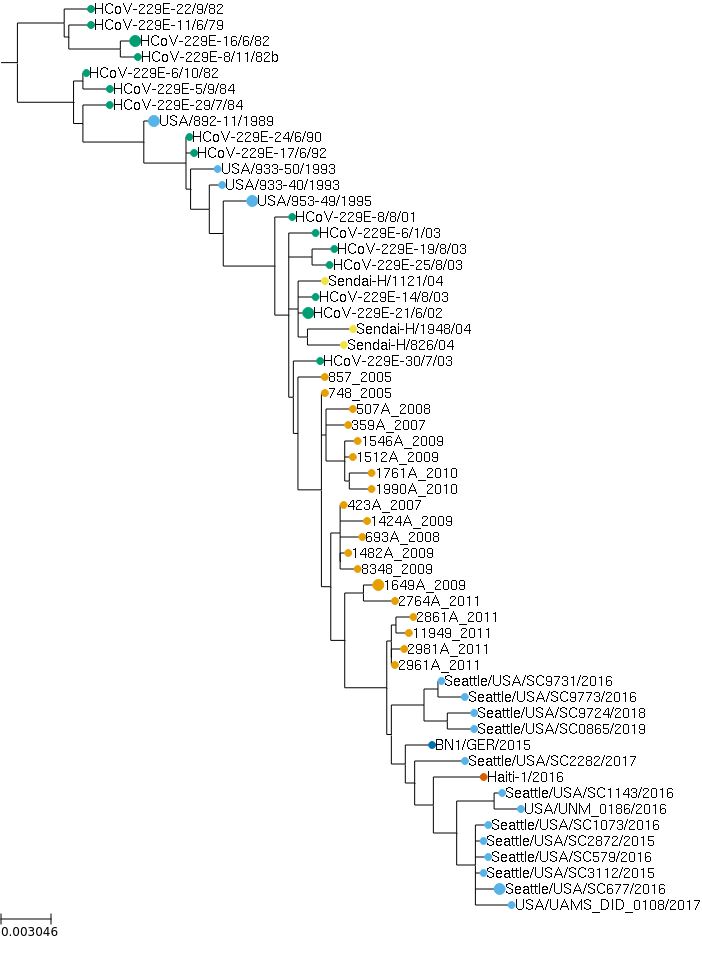

Reading tree from results/timetree/timetree.newick


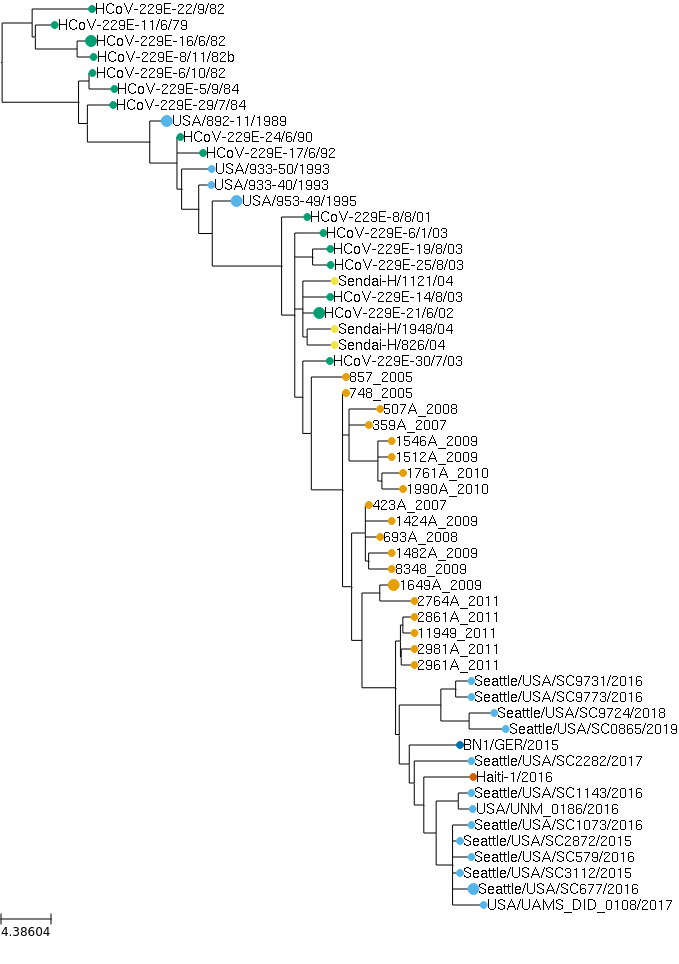

In [20]:
# function to create and style tree
def get_pretty_tree(treefile,
                    widthscale=500,
                    ):
    """Returns `(tree, tree_style)`."""
    
    t = ete3.Tree(treefile, format=1)
    
    ts = ete3.TreeStyle()
    ts.show_leaf_name = True  # show tip names
    height = t.get_farthest_node()[1]
    ts.scale = widthscale / height
    
    name_to_color = {name: country_to_color[country] for name, country in name_to_country.items()}
    
    for n in t.traverse():
        nstyle = ete3.NodeStyle()
        if n.is_leaf():
            nstyle['fgcolor'] = name_to_color[n.name]
            if n.name in names_to_annotate:
                nstyle['size'] = 11
            else:
                nstyle['size'] = 7
        else:
            nstyle['size'] = 0
        n.set_style(nstyle)

    return t, ts
    

for branch_len in ['divergence', 'time']:
    
    treefile = config[f"{branch_len}tree"]
    print(f"Reading tree from {treefile}")
    t, ts = get_pretty_tree(treefile)
    
    display(t.render('%%inline', tree_style=ts))
#    break

In [9]:
[n for n in t.traverse('postorder')][0]

Tree node 'HCoV-229E-22/9/82' (0x7f6c505d8e8)

In [10]:
t

Tree node 'NODE_0000008' (0x7f6c505d8c7)

In [11]:
t.get_farthest_leaf()

(Tree node 'Seattle/USA/SC0865/2019' (0x7f6c5059ea6), 43.86045)

In [12]:
2019 - 43

1976